In [1]:
import pandas as pd
import re
import numpy as np
import random
from math import sin, cos, sqrt, atan2, radians
import time
import matplotlib.pyplot as plt
from matplotlib import rc
from matplotlib.animation import FuncAnimation

In [2]:
def get_distance(lat1, lon1, lat2, lon2):
    R = 6373.0

    lat1 = radians(lat1)
    lon1 = radians(lon1)
    lat2 = radians(lat2)
    lon2 = radians(lon2)

    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = sin(dlat / 2) ** 2 + cos(lat1) * cos(lat2) * sin(dlon / 2) ** 2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))

    return R * c


def score(path, idx_dict, distances):
    res = 0
    for i in range(len(path) - 1):
        idx1 = idx_dict[path[i]]
        idx2 = idx_dict[path[i + 1]]
        res += distances[idx1][idx2]

    return res


def update_path(path, times=2):
    for i in range(times):
        selected = random.sample(path, k=2)
        city1 = selected[0]
        city2 = selected[1]
        pos1 = path.index(city1)
        pos2 = path.index(city2)
        path[pos1], path[pos2] = path[pos2], path[pos1]

    return path


def acceptance_ratio(cost, new_cost, temperature):
    p = np.exp(- cost / temperature)
    p_new = np.exp(- new_cost / temperature)

    if p == 0:
         return 0

    return p_new / p


In [3]:
def simpleSA(T, rate, path, distances, idx_dict):
    log = []
    cost = score(path, idx_dict, distances)

    cost_record = 0
    iter = 0
    while True:
        if iter % 5000 == 0:
            if cost_record == cost:
                break

            cost_record = cost
            print(cost_record)

        old_path = path.copy()
        path = update_path(path)
        new_cost = score(path, idx_dict, distances)

        alpha = acceptance_ratio(cost, new_cost, T)
        u = np.random.uniform(0, 1, 1)[0]
        if u <= alpha:
            cost = new_cost
            log.append(old_path)
        else:
            path = old_path

        T *= rate
        iter += 1
        
    return log, path

In [4]:
topN = 30

data = pd.read_csv("cities.csv")
data['population'] = data['population'].transform(lambda x: int(re.sub('\[\d\]', '', str(x))))
data['geo_lat'] = data['geo_lat'].astype('float')
data['geo_lon'] = data['geo_lon'].astype('float')

data.sort_values("population", axis=0, ascending=False, inplace=True, na_position='last')

data.city.fillna(data.region, inplace=True)
df = data[['city', 'population', 'geo_lat', 'geo_lon']]
df = df[:topN]

In [5]:
cities = list(df['city'])
cities_to_idx = {}
idx_to_cities = {}
for i in range(topN):
    cities_to_idx[cities[i]] = i
    idx_to_cities[i] = cities[i]

In [6]:
cities_dist = np.zeros((topN, topN))
for i in range(topN):
    for j in range(i):
        if i != j:
            city_a = df.loc[df['city'] == idx_to_cities[i]]
            city_b = df.loc[df['city'] == idx_to_cities[j]]

            distance = get_distance(city_a['geo_lat'], city_a['geo_lon'], city_b['geo_lat'], city_b['geo_lon'])

            cities_dist[i][j] = distance
            cities_dist[j][i] = distance

In [7]:
cities_pos = {}
for i in range(topN):
    line = df.iloc[i]
    
    cities_pos[line['city']] = (line['geo_lon'], line['geo_lat'])

In [24]:
initial_path = cities.copy()
random.shuffle(initial_path)

start_time = time.time()
path_log, result_path = simpleSA(225, 0.99996, initial_path, cities_dist, cities_to_idx)
print("--- %s seconds ---" % (time.time() - start_time))

55414.83561773689
20175.024201746186
21231.593802495725
17996.17246755847
16917.600079006228
17080.133814015076
14590.758535512858
14431.740953189672
14362.002756904905
14327.616711467283
14001.000630714148
13877.297265842659
--- 3.2330241203308105 seconds ---


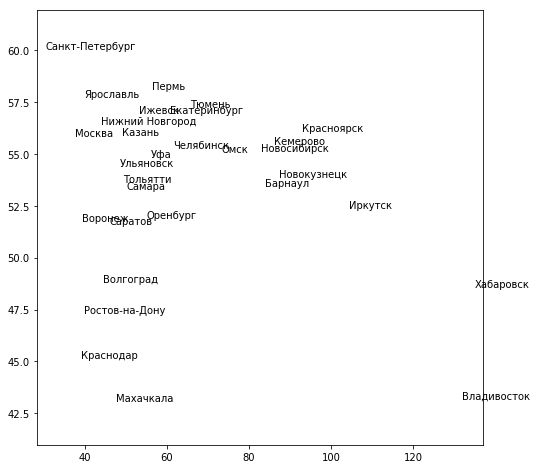

In [25]:
rc('animation', html='html5')
plt.style.use('seaborn-pastel')

padding = (2, 2, 2, 2)
x_lim = (min(list(df['geo_lon'])) - padding[0], max(list(df['geo_lon'])) + padding[1])
y_lim = (min(list(df['geo_lat'])) - padding[2], max(list(df['geo_lat'])) + padding[3])

fig = plt.figure(figsize=(8, 8))
ax = plt.axes(xlim=x_lim, ylim=y_lim)
line, = ax.plot([], [], lw=3)

def init():
    for city, pos in cities_pos.items():
        ax.annotate(city, (pos[0] + 0.1, pos[1] + 0.1))
    
    return line,

def animate(path):
    x_pos = []
    y_pos = []
    for city in path:
        x_pos.append(cities_pos[city][0])
        y_pos.append(cities_pos[city][1])
    
    line.set_data(x_pos, y_pos)
    
    return line,

drawable_path = path_log[0::1]
drawable_path.append(result_path)

anim = FuncAnimation(fig, animate, init_func=init, frames=drawable_path, interval=50, blit=True, repeat=False)
#anim.save('anima.mp4', writer='imagemagick')

In [26]:
anim